# Optimización de portafolios usando simulación Montecarlo

> La clase pasada vimos métodos de optimización convexos para la selección de portafolios. Vimos que se podía seleccionar el portafolio según sharpe, mínima varianza o máximo rendimiento. Sin embargo, todos estos casos caen en una región que llamamos frontera eficiente.

> En esta clase, veremos como obtener la frontera eficiente mediante simulación montecarlo. Compararemos con la que obtuvimos mediante optmización.

## 0. Descargar precios de cierre

In [4]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.covariance as skcov
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [5]:
def get_historical_closes(ticker, start_date, end_date=None):
    closes = web.DataReader(name=ticker, data_source='yahoo', start=start_date, end=end_date).sort_index('major_axis')
    return closes.loc['Adj Close',:]
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

Descargar precios de cierre de Apple, Amazon, Microsoft y Coca-Cola, entre el primero de enero del 2010 y el 31 de diciembre de 2016.

In [6]:
tickers = ['AAPL', 'MSFT', 'KO', 'AMZN']
start_date, end_date = '2010-01-01', '2016-12-31'
closes = get_historical_closes(tickers, start_date, end_date)
closes.plot(figsize=(8,6));

ImmediateDeprecationError: 
Yahoo Daily has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues


## 1. Riesgo del portafolio

Obtener rendimientos

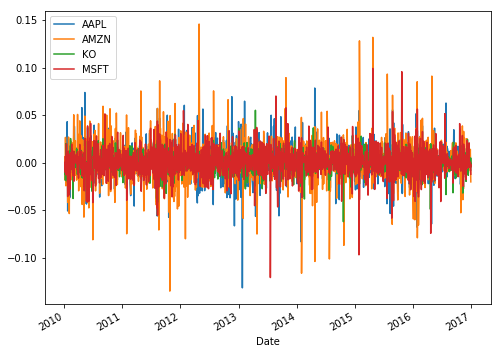

In [4]:
daily_ret = calc_daily_ret(closes)
daily_ret.plot(figsize=(8,6));

Media

In [6]:
daily_ret_mean = daily_ret.mean()
daily_ret_mean

AAPL    9.665e-04
AMZN    9.783e-04
KO      3.737e-04
MSFT    5.011e-04
dtype: float64

Matriz de covarianza

In [7]:
daily_ret_cov = daily_ret.cov()
daily_ret_cov

,AAPL,AMZN,KO,MSFT
AAPL,2.779e-04,1.097e-04,4.652e-05,9.611e-05
AMZN,1.097e-04,4.131e-04,5.631e-05,1.200e-04
KO,4.652e-05,5.631e-05,9.097e-05,5.714e-05
MSFT,9.611e-05,1.200e-04,5.714e-05,2.126e-04


Estimación de la covarianza en este [link](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices)

Más información en este otro [link](http://scikit-learn.org/stable/modules/covariance.html)

En el trabajo "Honey, I Shrunk the Sample Covariance Matrix'', (O. Ledoit and M. Wolf, 2003) aseveran en el abstract: 

    The central message of this paper is that nobody should be using the sample covariance matrix for the purpose of portfolio optimization. It contains estimation error of the kind most likely to perturb a mean-variance optimizer. In its place, we suggest using the matrix obtained from the sample covariance matrix through a transformation called shrinkage. This tends to pull the most extreme coefficients towards more central values, thereby systematically reducing estimation error where it matters most. Statistically, the challenge is to know the optimal shrinkage intensity, and we give the formula for that. Without changing any other step in the portfolio optimization process, we show on actual stock market data that shrinkage reduces tracking error relative to a benchmark index, and substantially increases the realized information ratio of the active portfolio manager.

El modulo `covariance` de la librería `sklearn` contiene una función para evaluar esta matriz robusta de covarianza: 

In [7]:
help(skcov.ShrunkCovariance)

Help on class ShrunkCovariance in module sklearn.covariance.shrunk_covariance_:

class ShrunkCovariance(sklearn.covariance.empirical_covariance_.EmpiricalCovariance)
 |  Covariance estimator with shrinkage
 |  
 |  Read more in the :ref:`User Guide <shrunk_covariance>`.
 |  
 |  Parameters
 |  ----------
 |  store_precision : boolean, default True
 |      Specify if the estimated precision is stored
 |  
 |  assume_centered : boolean, default False
 |      If True, data are not centered before computation.
 |      Useful when working with data whose mean is almost, but not exactly
 |      zero.
 |      If False, data are centered before computation.
 |  
 |  shrinkage : float, 0 <= shrinkage <= 1, default 0.1
 |      Coefficient in the convex combination used for the computation
 |      of the shrunk estimate.
 |  
 |  Attributes
 |  ----------
 |  covariance_ : array-like, shape (n_features, n_features)
 |      Estimated covariance matrix
 |  
 |  precision_ : array-like, shape (n_fea

In [8]:
#robust_cov_matrix= pd.DataFrame(skcov.EmpiricalCovariance().fit(daily_ret).covariance_,columns=daily_ret.columns,index=daily_ret.columns)
robust_cov_matrix= pd.DataFrame(skcov.ShrunkCovariance().fit(daily_ret).covariance_,columns=daily_ret.columns,index=daily_ret.columns)
robust_cov_matrix

,AAPL,AMZN,KO,MSFT
AAPL,2.749e-04,9.871e-05,4.184e-05,8.645e-05
AMZN,9.871e-05,3.964e-04,5.065e-05,1.080e-04
KO,4.184e-05,5.065e-05,1.067e-04,5.140e-05
MSFT,8.645e-05,1.080e-04,5.140e-05,2.161e-04


Comparar

In [9]:
daily_ret_cov

,AAPL,AMZN,KO,MSFT
AAPL,2.779e-04,1.097e-04,4.652e-05,9.611e-05
AMZN,1.097e-04,4.131e-04,5.631e-05,1.200e-04
KO,4.652e-05,5.631e-05,9.097e-05,5.714e-05
MSFT,9.611e-05,1.200e-04,5.714e-05,2.126e-04


## 2. Optimización de portafolios mediante montecarlo

Lo que haremos es generar muchos portafolios de manera aleatoria y calcular su rendimiento esperado y volatilidad (riesgo), para obtener la frontera eficiente...

In [12]:
num_portfolios = 10000 # Cantidad de portafolios a simular
r=0.015/252            # Tasa libre de riesgo
num_stocks = closes.columns.size

De forma cíclica...

In [19]:
import time

t0 = time.time()
results = np.zeros((num_portfolios, 3+num_stocks)) # Inicialización de vector de resultados

for i in range(num_portfolios):
    #Pesos aleatorios con la restricción de ponderación
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
 
    #Rendimiento y volatilidad
    portfolio_return = daily_ret_mean.T.dot(weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(robust_cov_matrix, weights))) * np.sqrt(252)
 
    #Resultados
    results[i,0] = portfolio_return
    results[i,1] = portfolio_std_dev
    #Sharpe
    results[i,2] = (results[i,0]-r) / results[i,1]
    #Iteraciones
    for j in range(len(weights)):
        results[i, j+3] = weights[j]

total_time = time.time()-t0
pd.set_option('display.max_columns', 7)
results_frame = pd.DataFrame(results,columns=(['Rendimiento','SD','Sharpe']+list(daily_ret.columns)))
results_frame

,Rendimiento,SD,Sharpe,AAPL,AMZN,KO,MSFT
0,0.196,0.191,1.024,0.287,0.323,0.101,0.289
1,0.153,0.201,0.759,0.134,0.101,0.044,0.720
2,0.137,0.151,0.908,0.160,0.062,0.486,0.291
3,0.222,0.208,1.066,0.565,0.252,0.032,0.151
4,0.178,0.185,0.962,0.472,0.010,0.156,0.362
...,...,...,...,...,...,...,...
9995,0.223,0.211,1.058,0.431,0.395,0.030,0.144
9996,0.140,0.176,0.792,0.106,0.072,0.243,0.578
9997,0.185,0.188,0.985,0.202,0.328,0.134,0.335
9998,0.193,0.180,1.071,0.501,0.132,0.255,0.111


In [20]:
total_time

2.729685068130493

In [16]:
# Max Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
# Min risk SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]
max_sharpe_port

Rendimiento    0.199
SD             0.181
Sharpe         1.097
AAPL           0.436
AMZN           0.256
KO             0.285
MSFT           0.023
Name: 3335, dtype: float64

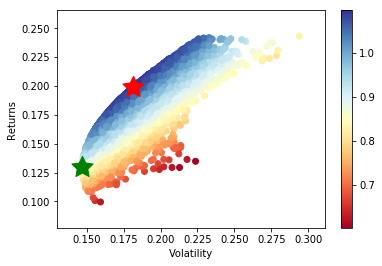

In [17]:
plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500);

<img style="float: left; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/a/a1/Scared_Girl.jpg" width="300px" height="100px" />

### Que horror usar ciclos

Realizar un código que haga lo mismo que el anterior pero sin usar ciclos

Temporizar y comparar...

In [22]:
t0 = time.time()
results = np.zeros((num_portfolios, 3+num_stocks)) # Inicialización de vector de resultados

weights = np.random.random((num_portfolios, num_stocks))
weights /= np.sum(weights, axis=1)[:, None]

#Rendimiento y volatilidad
portfolio_return = weights.dot(daily_ret_mean) * 252
portfolio_std_dev = np.sqrt(np.dot(weights,np.dot(robust_cov_matrix, weights.T)).diagonal()) * np.sqrt(252)

#Resultados
results[:,0] = portfolio_return
results[:,1] = portfolio_std_dev
#Sharpe
results[:,2] = (results[:,0]-r) / results[:,1]
#Iteraciones
results[:,3:] = weights

total_time = time.time()-t0

results_frame = pd.DataFrame(results,columns=(['Rendimiento','SD','Sharpe']+list(daily_ret.columns)))
results_frame

,Rendimiento,SD,Sharpe,AAPL,AMZN,KO,MSFT
0,0.188,0.186,1.010,0.595,0.018,0.325,0.061
1,0.234,0.223,1.047,0.431,0.479,0.027,0.063
2,0.135,0.173,0.780,0.052,0.101,0.297,0.551
3,0.163,0.197,0.823,0.229,0.087,0.032,0.652
4,0.194,0.187,1.037,0.436,0.163,0.106,0.295
...,...,...,...,...,...,...,...
9995,0.215,0.198,1.084,0.458,0.323,0.127,0.092
9996,0.174,0.173,1.005,0.346,0.111,0.202,0.340
9997,0.161,0.156,1.032,0.265,0.177,0.550,0.008
9998,0.190,0.184,1.033,0.228,0.372,0.239,0.161


In [23]:
total_time

1.0949881076812744

In [24]:
# Max Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
# Min risk SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]
max_sharpe_port

Rendimiento    0.197
SD             0.180
Sharpe         1.097
AAPL           0.434
AMZN           0.250
KO             0.305
MSFT           0.011
Name: 1843, dtype: float64

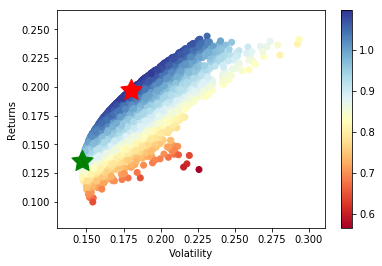

In [25]:
plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500);

## 3. Comparación

In [26]:
rfr=0.015/252            # Tasa libre de riesgo

def objfun(W, R):
    cov = skcov.ShrunkCovariance().fit(R).covariance_
    return 0.5*np.dot(np.dot(W,cov),W.T)

def jac(W, R):
    cov = skcov.ShrunkCovariance().fit(R).covariance_
    return np.dot(W,cov)

def calc_efficient_frontier(returns, num = 1000):
    nstocks = returns.columns.size
    results = np.zeros((num, 3+nstocks))
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    i = 0
    for r in np.linspace(min_mean, max_mean, num):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
                       {'type': 'eq', 'fun': lambda W: np.dot(W,np.mean(returns,axis=0))-r})
        optimalP = opt.minimize(objfun, weights, args=(returns,), jac=jac, method='SLSQP', constraints = constraints, bounds = bounds, options={'ftol': 1e-10, 'maxiter': 1000})
        if not optimalP.success: # handle error
            raise Exception(optimalP.message)
        results[i,0] = 252*np.round(r, 4) # 4 decimal places
        results[i,1] = np.sqrt(252)*np.round(np.std(np.sum(returns*optimalP.x,axis=1)), 6)
        results[i,2] = (results[i,0]-rfr)/results[i,1]
        results[i,3:]= optimalP.x
        i += 1
    return pd.DataFrame(results, columns=(['Rendimiento','SD','Sharpe']+list(daily_ret.columns)))

In [27]:
frontier_data = calc_efficient_frontier(daily_ret)

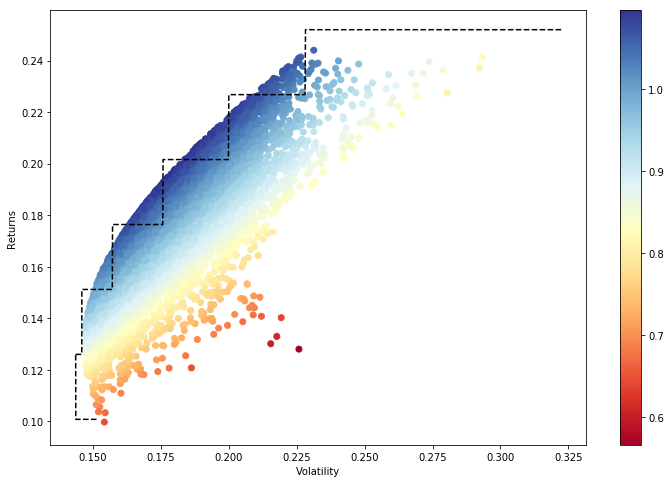

In [28]:
plt.figure(figsize=(12,8))
plt.plot(frontier_data['SD'], frontier_data['Rendimiento'], 'k--');

plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

Como ven, la función `scipy.optimize.minimize` tiene ciertos problemas en este caso... Este es un problema de programación cuadrática y lo mejor sería usar una función especializada para este tipo de problemas.

http://cvxopt.org/

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>